In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import random


In [2]:
# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get current working directory
cwd = os.getcwd()

# Define paths to dataset directories relative to current working directory
data_dir = os.path.join(cwd, "chest_xray")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define batch size for DataLoader
batch_size = 32

In [3]:
# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ChestXrayDataset(torch.utils.data.Dataset):
    """
    Custom dataset class to load and preprocess the Chest X-ray images dataset.
    
    Args:
        data_dir (str): Path to the dataset directory.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.image_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            cls_images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            self.image_paths.extend(cls_images)
        # Extract class labels from parent directory name
        self.targets = [self.classes.index(os.path.basename(os.path.dirname(img_path))) for img_path in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: Tuple containing the image and its target class.
        """
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target





In [4]:
# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
val_dataset = ChestXrayDataset(val_dir, transform=val_transform)
test_dataset = ChestXrayDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
# Initialize counts for normal and pneumonia images
num_normal = 0
num_pneumonia = 0

# Iterate through the dataset
for _, label in train_dataset:
    if label == 0:  # Assuming class 0 represents normal images
        num_normal += 1
    elif label == 1:  # Assuming class 1 represents pneumonia images
        num_pneumonia += 1

# Print the total number of normal and pneumonia images
print("Total number of normal images:", num_normal)
print("Total number of pneumonia images:", num_pneumonia)


Total number of normal images: 1341
Total number of pneumonia images: 3875


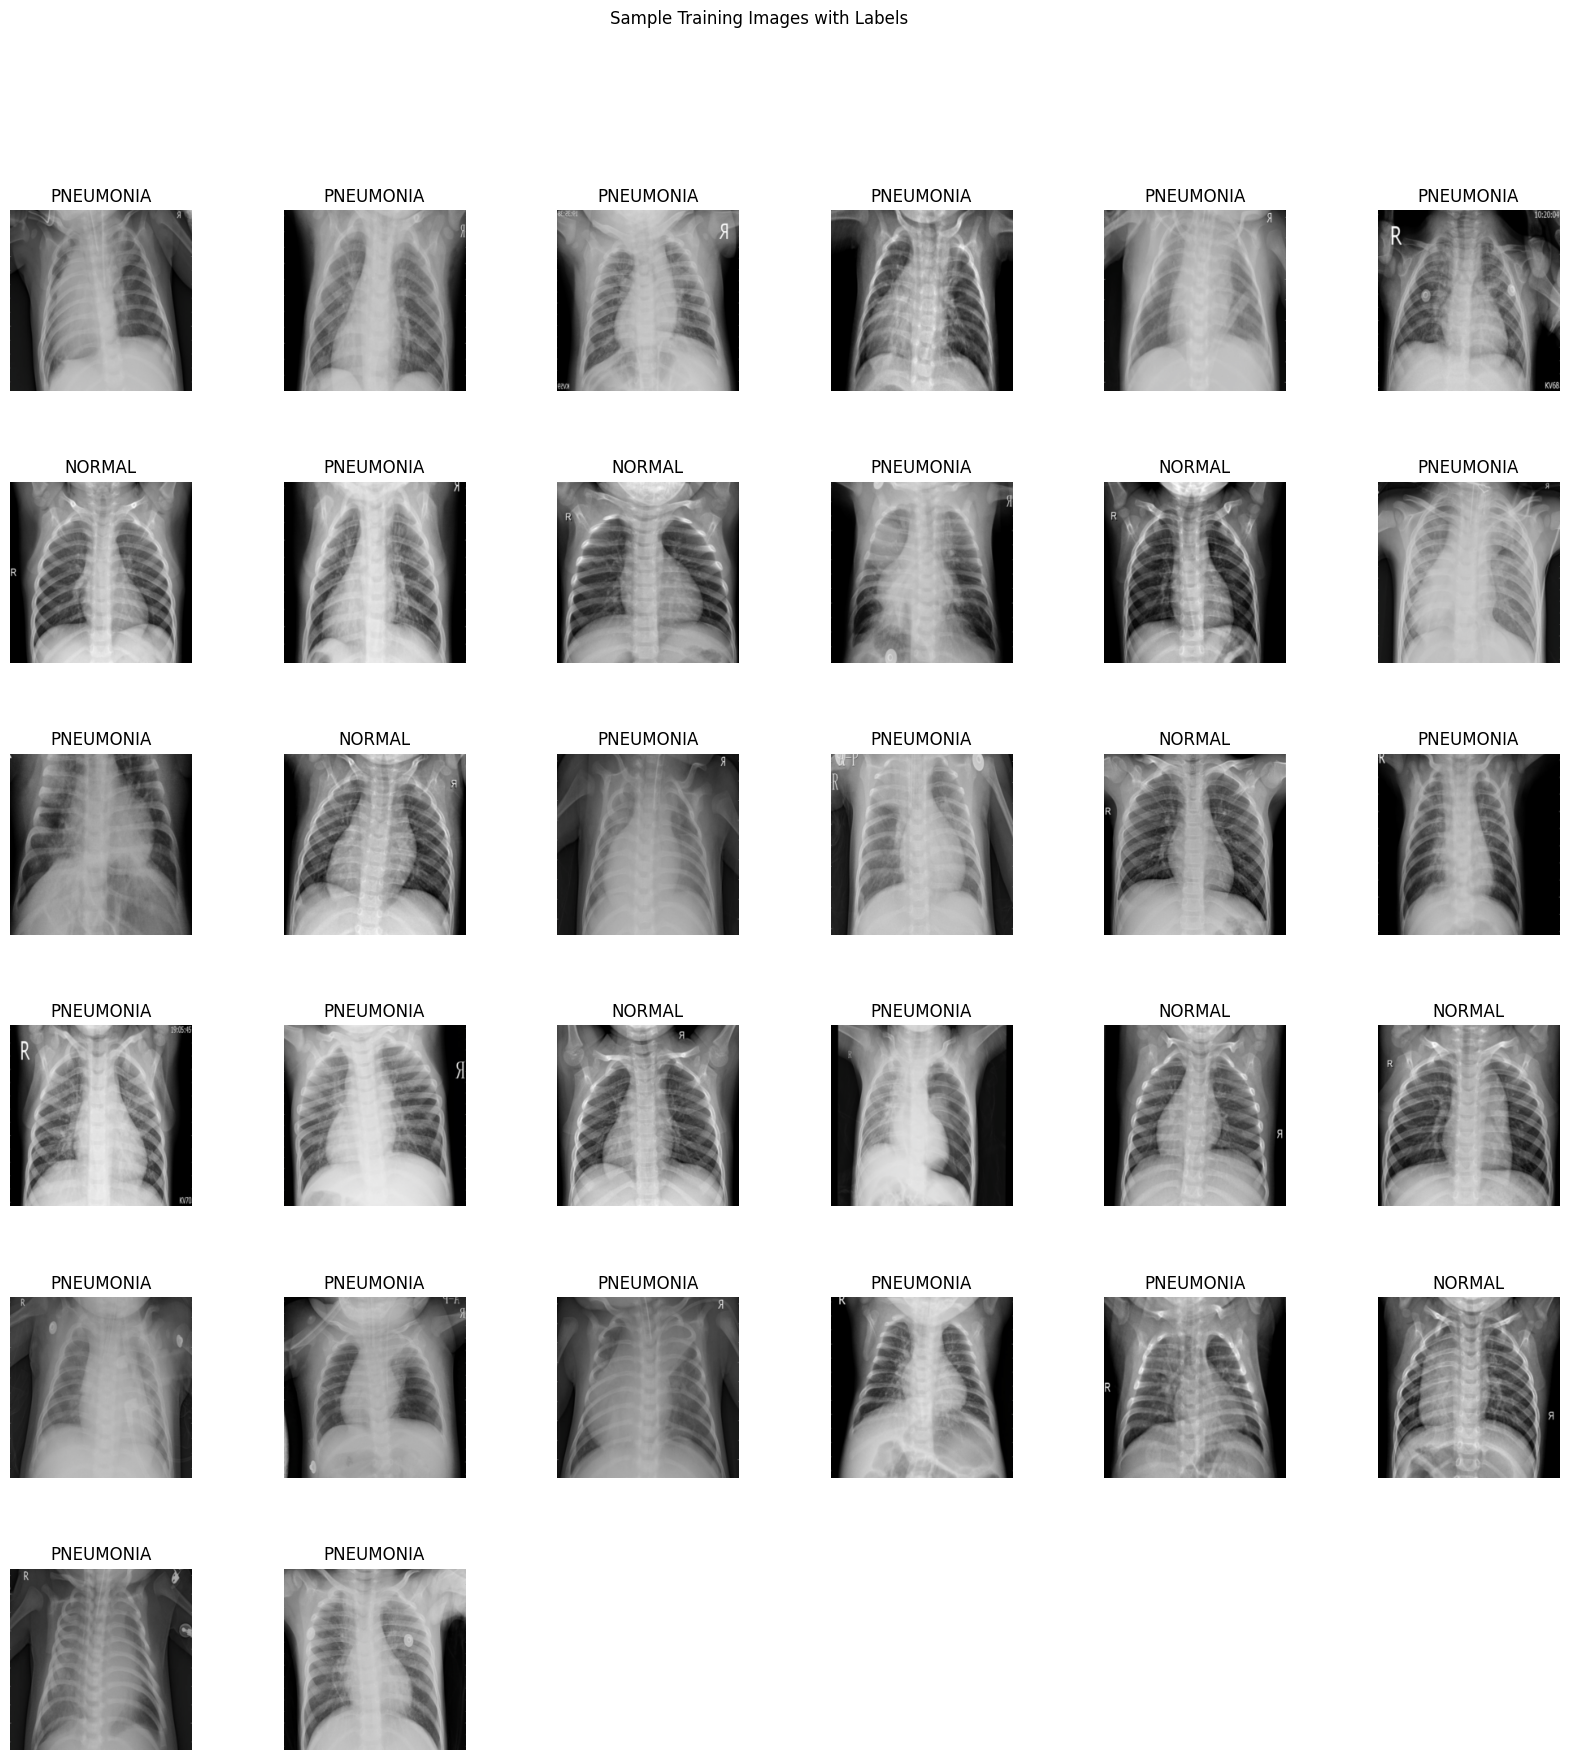

In [6]:
# Sanity check - visualize a batch of images
def imshow(inp, title=None):
    """Show a batch of images."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(50, 50)) 
    plt.imshow(inp)
    plt.axis('off')  # Turn off axis
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch and visualize with class labels
def imshow_with_labels(inp, classes, title=None):
    """Show a batch of images along with their class labels."""
    num_images = min(inp.size(0), 36)  # Ensure a maximum of 36 images are displayed
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = inp[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(train_dataset.classes[classes[i]])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for empty subplots
    if title is not None:
        plt.suptitle(title)
    plt.show()

# Visualize the batch of images along with class labels
imshow_with_labels(inputs, classes, title='Sample Training Images with Labels')

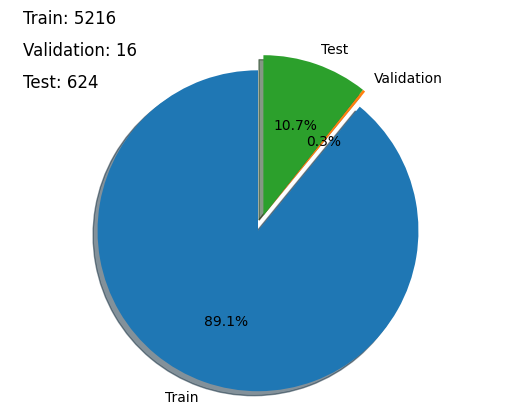

In [7]:
# Calculate sizes of each dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [train_size, val_size, test_size]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e., 'Train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add annotations to display the sizes
for i, size in enumerate(sizes):
    ax1.annotate(f'{labels[i]}: {size}', xy=(0, 0), xytext=(-1.5, 1.2 - i * 0.2), fontsize=12, color='black')

plt.show()


In [8]:
# Load pre-trained VGG-16 model
model = torchvision.models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Modify the fully connected layer for binary classification (2 classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 30

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the modified VGG model architecture
print(model)

# Sanity check to see if the model is moved to the correct device
print(f"Model is using {device}")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:

validation_subset_size = int(len(train_dataset) * 0.2)  

# Shuffle the indices of the training dataset
indices = list(range(len(train_dataset)))
random.shuffle(indices)

# Extract a subset of the training dataset for validation
validation_indices = indices[:validation_subset_size]
remaining_indices = indices[validation_subset_size:]

# Create datasets and dataloaders
val_subset_dataset = torch.utils.data.Subset(train_dataset, validation_indices)
train_subset_dataset = torch.utils.data.Subset(train_dataset, remaining_indices)

# Append the subset of training data to the validation dataset
val_dataset += val_subset_dataset

# Remove the subset data from the original training dataset
train_dataset = train_subset_dataset

# Create data loaders for the updated datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Sanity check: Print the sizes of the training and validation datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 4173
Validation dataset size: 1059


In [11]:
# Initialize variables for tracking best validation loss and corresponding epoch
best_val_loss = float('inf')
best_epoch = 0

# Define the number of epochs to wait if validation loss doesn't improve
patience = 5
counter = 0  # Counter to track the number of epochs with no improvement

# Initialize lists to store training and validation loss, and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    # Calculate training loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    # Calculate validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100. * correct / total
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
          f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Store the values for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        
    # Check for early stopping
    if counter >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
        break

# Print the best validation loss and corresponding epoch
print(f'Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}')

Epoch [1/30], Train Loss: 0.2273, Train Acc: 90.10%, Val Loss: 0.1669, Val Acc: 92.92%, Learning Rate: 0.001000
Epoch [2/30], Train Loss: 0.1743, Train Acc: 93.03%, Val Loss: 0.1281, Val Acc: 94.90%, Learning Rate: 0.001000
Epoch [3/30], Train Loss: 0.1697, Train Acc: 93.48%, Val Loss: 0.1411, Val Acc: 94.43%, Learning Rate: 0.001000
Epoch [4/30], Train Loss: 0.1603, Train Acc: 93.77%, Val Loss: 0.1193, Val Acc: 95.75%, Learning Rate: 0.001000
Epoch [5/30], Train Loss: 0.1736, Train Acc: 93.24%, Val Loss: 0.1084, Val Acc: 96.13%, Learning Rate: 0.001000
Epoch [6/30], Train Loss: 0.1583, Train Acc: 93.58%, Val Loss: 0.1451, Val Acc: 94.15%, Learning Rate: 0.001000
Epoch [7/30], Train Loss: 0.1713, Train Acc: 93.12%, Val Loss: 0.1133, Val Acc: 96.13%, Learning Rate: 0.001000
Epoch [8/30], Train Loss: 0.1471, Train Acc: 94.06%, Val Loss: 0.1104, Val Acc: 95.75%, Learning Rate: 0.001000
Epoch [9/30], Train Loss: 0.1679, Train Acc: 93.41%, Val Loss: 0.1157, Val Acc: 95.37%, Learning Rate: 0

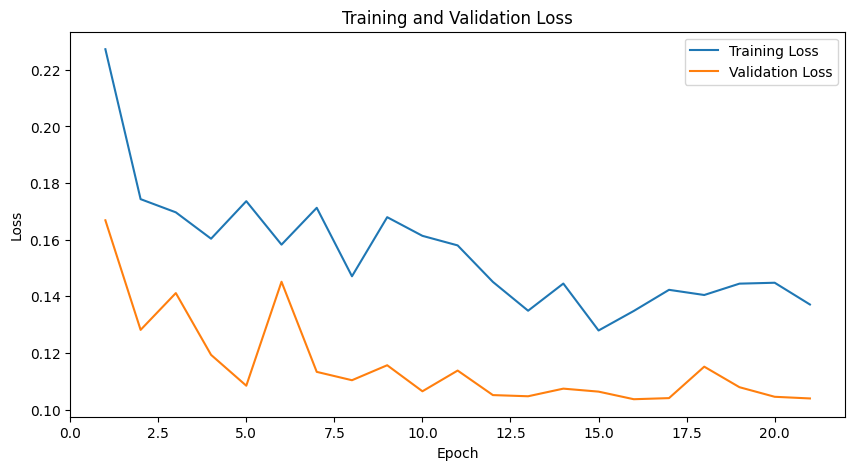

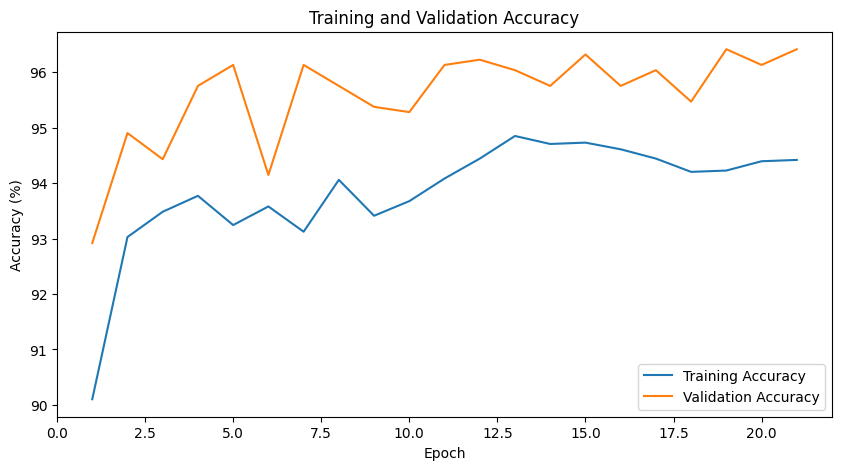

In [12]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


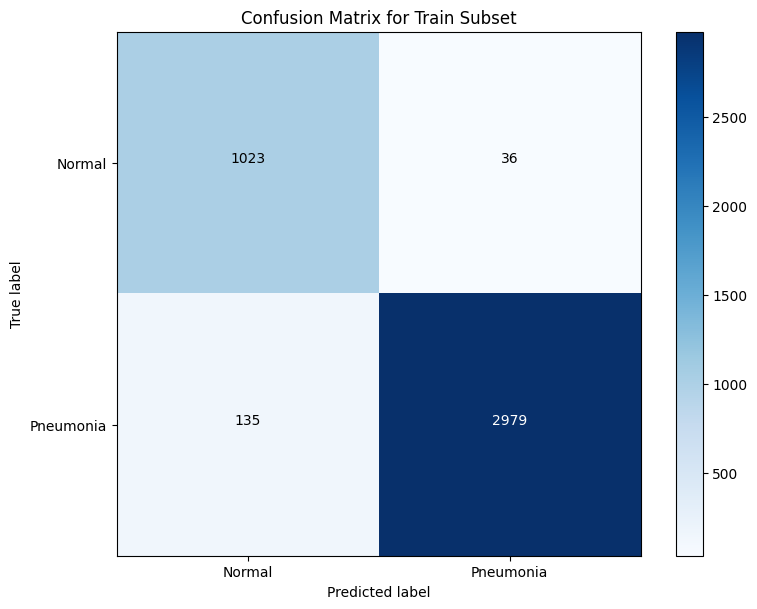

Metrics for Train subset:
Accuracy: 0.9590
Precision: 0.9881
Recall: 0.9566
F1 Score: 0.9721
Confusion Matrix:
[[1023   36]
 [ 135 2979]]

Classification Report for Train subset:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1059
           1       0.99      0.96      0.97      3114

    accuracy                           0.96      4173
   macro avg       0.94      0.96      0.95      4173
weighted avg       0.96      0.96      0.96      4173




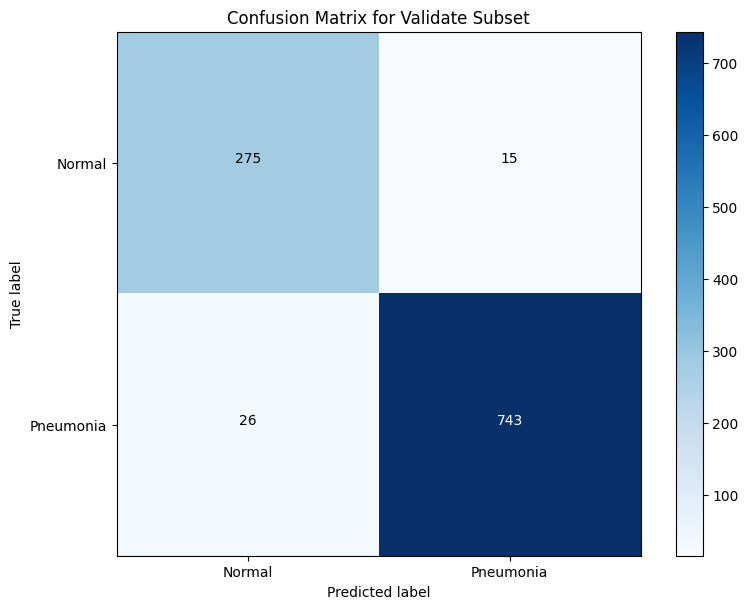

Metrics for Validate subset:
Accuracy: 0.9613
Precision: 0.9802
Recall: 0.9662
F1 Score: 0.9731
Confusion Matrix:
[[275  15]
 [ 26 743]]

Classification Report for Validate subset:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       290
           1       0.98      0.97      0.97       769

    accuracy                           0.96      1059
   macro avg       0.95      0.96      0.95      1059
weighted avg       0.96      0.96      0.96      1059




In [24]:
def evaluate_model(loader, name):
    """
    Evaluate the trained model on the specified data loader and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the dataset to evaluate.
        name (str): Name of the subset (e.g., "Train", "Validate").

    Returns:
        None
    """
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = ["Normal", "Pneumonia"]  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions)
    print(f"Classification Report for {name} subset:\n{report}\n")

# Evaluate on train subset
evaluate_model(train_loader, "Train")

# Evaluate on validate subset
evaluate_model(val_loader, "Validate")

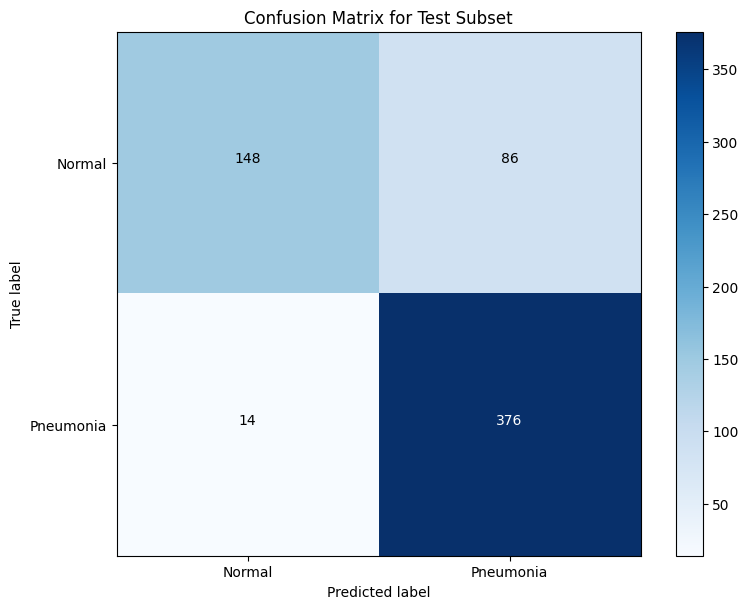

Metrics for Test subset:
Accuracy: 0.8397
Precision: 0.8139
Recall: 0.9641
F1 Score: 0.8826
Confusion Matrix:
[[148  86]
 [ 14 376]]

Classification Report for Test subset:
              precision    recall  f1-score   support

      Normal       0.91      0.63      0.75       234
   Pneumonia       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624


Total Correct: 524.0 
Total Test Images: 624.0


In [23]:
def evaluate_model_test(loader, name):
    """
    Evaluate the trained model on the specified data loader (test set), store true labels, predicted labels, and input images for visualization, and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the test dataset to evaluate.
        name (str): Name of the subset (e.g., "Test").

    Returns:
        true_labels (list): True labels.
        pred_labels (list): Predicted labels.
        input_images (list): Input images for visualization.
        accuracy (float): Accuracy.
        precision (float): Precision.
        recall (float): Recall.
        f1 (float): F1 Score.
        confusion_matrix (array): Confusion matrix.
    """
    model.eval()
    predictions = []
    ground_truths = []
    input_images = []
    running_correct = 0.0
    running_total = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())
            input_images.extend(inputs.cpu().numpy())

            # Update running correct and total
            running_total += targets.size(0)
            running_correct += predicted.eq(targets).sum().item()

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix with labels
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = ["Normal", "Pneumonia"]  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions, target_names=classes)
    print(f"Classification Report for {name} subset:\n{report}\n")

    print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))

    return ground_truths, predictions, input_images, accuracy, precision, recall, f1, cm

# Call the function and store the returned values
true_labels, pred_labels, input_images, accuracy, precision, recall, f1, cm = evaluate_model_test(test_loader, "Test")


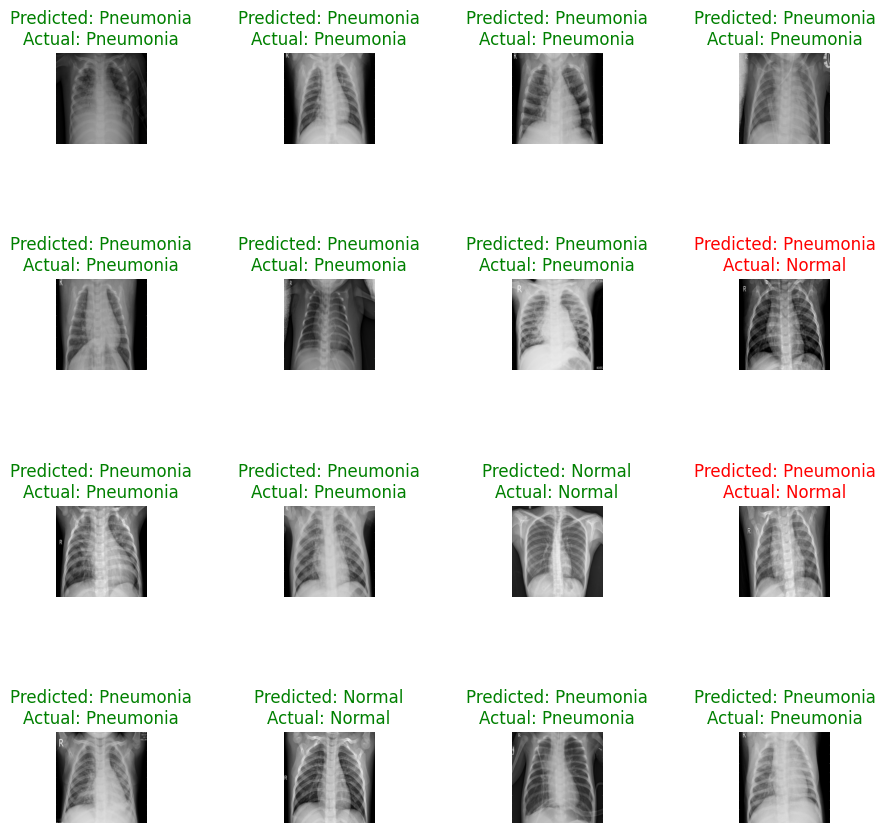

In [22]:
# Shuffle indices
indices = list(range(len(input_images)))
random.shuffle(indices)

# Define the class names
class_names = ['Normal', 'Pneumonia']

# Visualize the images along with predicted and true labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=1.5, wspace=1.5)
x = 0
for i in range(4):
    for j in range(4):
        # Get the image and labels using shuffled indices
        index = indices[x]
        inp = input_images[index].squeeze()
        true_label = true_labels[index]
        pred_label = pred_labels[index]

        # Normalize the image for display
        inp = inp.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


In [16]:

#  save the model 
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)  # Create the directory 
model_path = os.path.join(save_dir, 'trained_model.pth')
torch.save(model.state_dict(), model_path)
